<h1> SGWB Parameter Space Analysys</h1> 

In the following, we'll implement a notebook that, given the required Probability Distribution Functions (PDF) describing a Black Hole population(BH), generates the figure of merit for the predicted analytical Stochastic Gravitational Wave Background(SGWB) in function of the amplitude and redshift range of the merging rate.
First of all, we need to import some modules ! 

In [1]:
import numpy as np
import scipy.special as sc
import statistics as st
import random
import os
import IPython
import pandas as pd
import pickle
import multiprocessing as mp
import scipy.stats as scst
from tqdm import tqdm
from scipy import interpolate
from scipy.interpolate import interp1d
from scipy.integrate import quad, simpson
from scipy.stats import poisson
from scipy.special import gamma, hyp1f1
from scipy.optimize import minimize
from pycbc import waveform as wf
from multiprocessing import Pool, Manager, Process, Value, Array
from functools import partial
from LISAhdf5 import LISAhdf5,ParsUnits
from astropy.cosmology import Planck18 as cosmo
%matplotlib inline
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.style.use("seaborn-v0_8-white")

<h2> Global Variables of the Simulation </h2>

The global variables of the simulation will be set to :

In [2]:
# Merger distribution parameters

T_obs = 10. # Lisa or LIGO estimated years of observation
efficiency = 1. # Lisa effective usefull time percentage for observations
max_tc = 10000. # max years of coalescence time for a BBH mergine event
SNR_Trsh = 8. # Value of SNR after which a source is considered detectable
SFR_zpeak = 1.9 # Value of the peak of the SFR given the model

#General Constants 

c = 299792.46 # speed of light in Km/sec
G = 6.674*(10.**(-11.)) # Gravitational constant in m^3⋅kg^−1⋅s^−2
sol_mass = 1.988e30 # Value of the Solar Mass in Kg
MPc = 3.08567758149137*1e22 # meters
GPc = MPc*1e3 # meters
h = 0.678
H_0 = 67.8*1e3/MPc # Hubble constant in 1/(s)
Omega_m = 0.3 # Matter density in our universe
Omega_lambda = 0.7 # Cosmological constant density in our universe
Omega_k = 0. # Curvature density in our universe
rho_c = (3.*(H_0**2.))/(8.*np.pi*G) # Critical density in our universe
year = 365.25*24*60*60 # Years in second 
    
# Precision settings for the binned variables

n_jobs = 12 # 80 # Different values for laptop/server
df_nm = 'DetectorHorizonValues.h5'

The analytical SNR approximation can run using the following two modes for the inclination approximation:

In [3]:
Inc_mode = 'max_i'  # Maximize the estimated SNR by assuming perfect inclination in respect to the detector
#Inc_mode = 'avg_i' # Average the estimated SNR by integrating over all the possible inclinations in respect to the detector

<h2> Flag definition and selection </h2>

In this section, we will define some flags to set the execution of this notebook. We have:

In [4]:
compute_results = False # If true, the results of the cosmic horizon will be generated by the code. If not the generated dataset will be loaded

We can choose between running the horizon results anew or loading a pre-existing dataset by changing the:

In [5]:
#compute_results = True

<h2> Utility functions </h2>

In the following, we are going to define some useful generical functions that will be needed to present the results.
We will start with a function that can be used to convert matplotlib contour line to arrays.

In [6]:
def get_contour_verts(cn):
    # Given a set of contour line, save them as a dictionary
    contours = []
    # for each contour line
    for cc in cn.collections:
        paths = []
        # for each separate section of the contour line
        for pp in cc.get_paths():
            xy = []
            # for each segment of that section
            for vv in pp.iter_segments():
                xy.append(vv[0])
            paths.append(np.vstack(xy))
        contours.append(paths)

    return contours

<h2> Standard Cosmological Functions </h2>

First of all, we'll need a function that allow us to convert from redshift to Gigaparsec :

In [7]:
# Just a function to convert from Z to GPC using Hubble Law, in order to obtain the comoving distance

z_mi = 1.e-5
z_Ma = 1.e8
z_prec = 10000

def H(z):
    return np.sqrt((H_0**2.)*(Omega_m*((1. + z)**3.) + Omega_k*((1. + z)**2.) + Omega_lambda))

def Z_to_Gpc(z):
    
    # Remove the commented part to use a linear approximation of the Hubble law for low z 
    
    #if(zmax <= 0.5):
    #    return ((z*c*(10**(-3)))/(H_0)) # only valid for z < 0.5
    #else:
        
        span_z = np.logspace(np.log10(z_mi),np.log10(z),z_prec)
        # Beware, would fail if the span z is created in logarithmic scale !
        
        Int_Z = c*(10**(-3))*simpson(1./(H(span_z)*(MPc/1.e3)), span_z, axis=0)
    
        return Int_Z
    
def Z_to_HubbleTime(z):
    
    span_z = np.logspace(np.log10(z),np.log10(z_Ma),z_prec)
        
    # Beware, would fail if the span z is created in logarithmic scale !
        
    
    Int_Z = simpson(1./(H(span_z)*(1. + span_z)), span_z, axis=0)
    
    return Int_Z
    
t_0 = Z_to_HubbleTime(1.e-12) # Can't put 0 as the logarithmic scale would fail        

we also need a function that estimates the differential comoving volume in function of the redshift :

In [8]:
#In the following function, the differential comoving volume in function of the redshift will be estimated as a spherical surface, it need to be integrated over dr to obtain the real volume 

def DeVC(z, Delta_z):
    r = dist_func(z)
    z_2 = z + 0.5*Delta_z
    z_1 = z_2 - Delta_z
    Delta_r = dist_func(z_2) - dist_func(z_1)
    return ((4.*np.pi*(r**2.)*Delta_r)/Delta_z)

Another recurring parameter for inspiralling events is the Chirp Mass, given the mass of the two events involved in the binary merging :

In [9]:
# Function that return the Chirp Mass of a binary merging event

def ChirpMass(m1,m2): 
   return ((m1*m2)**(3./5.))/((m1+m2)**(1./5.))

together with the effective spin :

In [10]:
#Function that given the spin and spin tilt gives the effective spin

def EffectiveSpin(m1, m2, a1, a2, st_a1, st_a2):
    res = (m1*a1*cos(st_a1))/(m1 + m2) + (m2*a2*cos(st_a1))/(m1 + m2) # Hope so, better to double check

<h2> Detector sensitivity curves </h2>

The list of available detectors is given by:


In [11]:
Det_names = ['aplusLIGO', 'ET']

We start by implementing the analytical SNR on the [a+ LIGO](https://dcc.ligo.org/public/0149/T1800042/004/T1800042-v4.pdf) configuration, the detector frequency range for this configuration is given by :

In [12]:
LIGO_f = 5. #Hz
LIGO_F = 5000. #Hz
LIGO_fprec = 5000

LIGO_fran = np.linspace(LIGO_f,LIGO_F, LIGO_fprec)
LIGO_mfran = 0.5*(LIGO_fran[1::] + LIGO_fran[:-1:])


and its sensitivity curve can be loaded from the following .txt:

In [13]:
aplusLIGO_Sens = pd.read_csv('AplusDesign.txt', sep = "  ", engine = 'python')
LIGO_Sh = interp1d(aplusLIGO_Sens.Frequency, (aplusLIGO_Sens.aplusLIGO_Sh**2.), fill_value="extrapolate")

LIGO_cmi = LIGO_mfran*0.

# Estimating the integrated factor of the analytical SNR estimator in order to fit an interpolator

for i in range(len(LIGO_fran) - 1):
            
    if (i == 0):
        LIGO_cmi[i] = (LIGO_fran[i + 1] - LIGO_fran[i])*((LIGO_mfran[i]**(-7./3.))/(LIGO_Sh(LIGO_mfran[i])))
    else:
        LIGO_cmi[i] = (LIGO_fran[i + 1] - LIGO_fran[i])*((LIGO_mfran[i]**(-7./3.))/(LIGO_Sh(LIGO_mfran[i])))\
        + LIGO_cmi[i - 1]

aplusAnSNR_IntFac = interp1d(LIGO_mfran, LIGO_cmi, fill_value="extrapolate")

we can now implement the analytical SNR on the [ET](https://www.et-gw.eu/index.php) configuration, the detector frequency range in this case is given by:


In [14]:
ET_f = 0.1 #Hz
ET_F = 10000. #Hz
ET_fprec = 5000

ET_fran = np.linspace(LIGO_f,LIGO_F, LIGO_fprec)
ET_mfran = 0.5*(ET_fran[1::] + ET_fran[:-1:])

while its sensitivity curve can be loaded from the following .txt:

In [15]:
ET_Sens = pd.read_csv('ETSens.txt', sep = "   ", engine = 'python')
ET_Sh = interp1d(ET_Sens.Frequency, (ET_Sens.ETSensD_Sum**2.), fill_value="extrapolate")

ET_cmi = ET_mfran*0.

# Estimating the integrated factor of the analytical SNR estimator in order to fit an interpolator

for i in range(len(ET_fran) - 1):
            
    if (i == 0):
        ET_cmi[i] = (ET_fran[i + 1] - ET_fran[i])*((ET_mfran[i]**(-7./3.))/(ET_Sh(ET_mfran[i])))
    else:
        ET_cmi[i] = (ET_fran[i + 1] - ET_fran[i])*((ET_mfran[i]**(-7./3.))/(ET_Sh(ET_mfran[i])))\
        + ET_cmi[i - 1]

ETAnSNR_IntFac = interp1d(ET_mfran, ET_cmi, fill_value="extrapolate")

<h2> Analytcal SNR estimator </h2>

In order to understand the number of resolvable events for each population, we are now gonna implement an analytical SNR approximator as presented in [S. Babak et al.](https://arxiv.org/abs/2108.01167). The frequency of coalescence can be approximated by using the $f_{ISCO}$.

In [16]:
def GetFisco(m1,m2):
    M = m1 + m2 # Masses need to be in the source frame !
    freq = (1./(6.*np.sqrt(6)*np.pi))*((c*1000)**3.)/(G*M*sol_mass) # Taken from eq 4.39 Maggiore
    return freq

To fasten the code, we will choose two different approximations for the inclination. Depending on the choosen mode, the inclination of the events will be used differently in the waveform approximation:

In [17]:
if Inc_mode == 'max_i':
    inc_fac = 8. # Signal maximized using best inclination
if Inc_mode == 'avg_i':
    inc_fac = 16./5. # Signal averaged over the possible inclinations

We can finally define the following function to estimate the analytical SNR:

In [18]:
# Shape of the waveform used for the SNR calculation
def Stas_WF(f, m1, m2, DL):
    Ch_M = ChirpMass(m1, m2)
    res = (2./(np.pi)**(2./3.))*np.sqrt(5./96.)*(((sol_mass*Ch_M*G)**(5./6.))/(DL*MPc))*(1./(c*1000)**(3./2.))*(f**(-7./6.))
    return res

# Estimating the analytical SNR

def AnalSNR(z, m1, m2, detector):
    #Redshifting the masses
    m1 = m1*(1. + z)
    m2 = m2*(1. + z)
    ChMass = ChirpMass(m1,m2)
    Dl = (1. + z)*dist_func(z)
    if detector == 'aplusLIGO':
        LIGO_fend = min(GetFisco(m1, m2), LIGO_F)
        res = np.sqrt(inc_fac*(aplusAnSNR_IntFac(LIGO_fend) - aplusAnSNR_IntFac(LIGO_f))*(((np.sqrt(5./96.)*((ChMass*sol_mass*G)**(5./6.)))/(Dl*GPc*np.pi**(2./3.)))**2.)*(1./(c*1000)**3.))
    if detector == 'ET':
        ET_fend = min(GetFisco(m1, m2), ET_F)
        res = np.sqrt(inc_fac*(ETAnSNR_IntFac(ET_fend) - ETAnSNR_IntFac(ET_f))*(((np.sqrt(5./96.)*((ChMass*sol_mass*G)**(5./6.)))/(Dl*GPc*np.pi**(2./3.)))**2.)*(1./(c*1000)**3.))
    
    return res 

alternatively, we can also estimate the analytical SNR using the PyCBC waveforms:

In [19]:
def IMRPhenomD_AnalSNR(z, m1, m2):
    # Return an array composed of [SNR_aplusLIGO, SNR_ET]
    Dl = (1. + z)*dist_func(z)*(1.e3)
    
    # Creating the waveform using pycbc
    
    wave = wf.get_fd_waveform(approximant = 'IMRPhenomD', mass1 = m1*(1. + z), mass2 = m2*(1. + z), distance = Dl, delta_f = 0.5, f_lower = 0.5, spin1z=1., spin2z = 1.) # Mass need to be redshifted, distance in megaparsec
    frq_span = wave[0].get_sample_frequencies() # 0 is for the + waveform, 1 is for x
    
    # Getting the mid point of the frequency and waveform array to integrate using trapeze method
    
    mid_frq = np.array(0.5*(frq_span[1::] + frq_span[:-1:]))
    mid_wave = np.array(0.5*(abs(wave[0])[1::] + abs(wave[0])[:-1:]))
    df = np.array(frq_span[1::] - frq_span[:-1:])
    
    # Cutting the waveform for frequency not in LIGO
    
    if min(mid_frq) < LIGO_f:
        good_idx = mid_frq > LIGO_f
        LIGO_frq = mid_frq[good_idx]
        LIGO_df = df[good_idx]
        LIGO_wave = mid_wave[good_idx]
    else:
        LIGO_frq = mid_frq
        LIGO_df = df
        LIGO_wave = mid_wave
    
    
    if max(LIGO_frq) > LIGO_F:
        good_idx = LIGO_frq < LIGO_F
        LIGO_frq = LIGO_frq[good_idx]
        LIGO_df = LIGO_df[good_idx]
        LIGO_wave = LIGO_wave[good_idx]
        
    # Cutting the waveform for frequency not in LIGO
    
    if min(mid_frq) < ET_f:
        good_idx = mid_frq > ET_f
        ET_frq = mid_frq[good_idx]
        ET_df = df[good_idx]
        ET_wave = mid_wave[good_idx]
    else:
        ET_frq = mid_frq
        ET_df = df
        ET_wave = mid_wave
    
    if max(ET_frq) > ET_F:
        good_idx = ET_frq < ET_F
        ET_frq = ET_frq[good_idx]
        ET_df = ET_df[good_idx]
        ET_wave = ET_wave[good_idx]
    
    #Now estimating the SNRs 
       
    aplusLIGO_SNR = 4.*(2./5.)*simpson((LIGO_wave**2.)/LIGO_Sh(LIGO_frq), LIGO_frq)
    ET_SNR = 4.*(2./5.)*(3./4.)*simpson((ET_wave**2.)/ET_Sh(ET_frq), ET_frq)
    
    return [np.sqrt(aplusLIGO_SNR), np.sqrt(ET_SNR)];

In [20]:
def IMRPhenomXHM_AnalSNR(z, m1, m2):
    # Return an array composed of [SNR_aplusLIGO, SNR_ET]
    Dl = float(cosmo.luminosity_distance(z).value)
    
    # Creating the waveform using pycbc
    
    wave = wf.get_fd_waveform(approximant = 'IMRPhenomXHM', mass1 = m1*(1. + z), mass2 = m2*(1. + z), distance = Dl, delta_f = 0.5, f_lower = 0.5, spin1z=1., spin2z = 1.) # Mass need to be redshifted, distance in megaparsec
    frq_span = wave[0].get_sample_frequencies() # 0 is for the + waveform, 1 is for x
    
    # Getting the mid point of the frequency and waveform array to integrate using trapeze method
    
    mid_frq = np.array(0.5*(frq_span[1::] + frq_span[:-1:]))
    mid_wave = np.array(0.5*(abs(wave[0])[1::] + abs(wave[0])[:-1:]))
    df = np.array(frq_span[1::] - frq_span[:-1:])
    
    # Cutting the waveform for frequency not in LIGO
    
    if min(mid_frq) < LIGO_f:
        good_idx = mid_frq > LIGO_f
        LIGO_frq = mid_frq[good_idx]
        LIGO_df = df[good_idx]
        LIGO_wave = mid_wave[good_idx]
    else:
        LIGO_frq = mid_frq
        LIGO_df = df
        LIGO_wave = mid_wave
    
    
    if max(LIGO_frq) > LIGO_F:
        good_idx = LIGO_frq < LIGO_F
        LIGO_frq = LIGO_frq[good_idx]
        LIGO_df = LIGO_df[good_idx]
        LIGO_wave = LIGO_wave[good_idx]
        
    # Cutting the waveform for frequency not in LIGO
    
    if min(mid_frq) < ET_f:
        good_idx = mid_frq > ET_f
        ET_frq = mid_frq[good_idx]
        ET_df = df[good_idx]
        ET_wave = mid_wave[good_idx]
    else:
        ET_frq = mid_frq
        ET_df = df
        ET_wave = mid_wave
    
    if max(ET_frq) > ET_F:
        good_idx = ET_frq < ET_F
        ET_frq = ET_frq[good_idx]
        ET_df = ET_df[good_idx]
        ET_wave = ET_wave[good_idx]
    
    #Now estimating the SNRs 
       
    aplusLIGO_SNR = 4.*(2./5.)*simpson((LIGO_wave**2.)/LIGO_Sh(LIGO_frq), LIGO_frq)
    ET_SNR = 4.*(2./5.)*(3./4.)*simpson((ET_wave**2.)/ET_Sh(ET_frq), ET_frq)
    
    return [np.sqrt(aplusLIGO_SNR), np.sqrt(ET_SNR)];

In [21]:
# Function to compute the horizon distance give an SNR


def SNR_distance(mass, snr_val, guess_LIGO = 0.5, guess_ET = 1.0):

    
    # Results on A+ Ligo

    snr_lev = lambda z : (IMRPhenomXHM_AnalSNR(z, mass, mass)[0] -snr_val
                            )**2
    result  = minimize(snr_lev, guess_LIGO, method='Nelder-Mead', #'L-BFGS-B', 
                    #options={'ftol':1e-3, 'eps':1e-3}).x
                    options={'xatol':1e-3, 'fatol':1e-3}).x
    LIGO_dist = result[0]
    
    # Results on ET

    snr_lev = lambda z : (IMRPhenomXHM_AnalSNR(z, mass, mass)[1] -snr_val
                            )**2
    result  = minimize(snr_lev, guess_ET, method='Nelder-Mead', #'L-BFGS-B', 
                    #options={'ftol':1e-3, 'eps':1e-3}).x
                    options={'xatol':1e-3, 'fatol':1e-3}).x
    ET_dist = result[0]
    
    return [2.*mass, LIGO_dist, ET_dist]

<h2> Setting of the analyzed phase space </h2>

The simulation will be spanned over the following range of variables :

In [22]:
# Boundaries of the variable spans

z_min = 1.e-3
z_max = 150
z_prec = 10000

M_min = 3.
M_max = 147.
M_prec = 147 #49 # 

# Inizialization of the Hubble time

t_0 = Z_to_HubbleTime(1.e-12) # Can't put 0 as the logarithmic scale would fail


# Initialization of the redshift parameter space

ran_z = np.logspace(np.log10(z_min), np.log10(z_max), z_prec)
ran_d = Z_to_Gpc(ran_z)
dist_func = interp1d(ran_z, ran_d)
ran_d = 0.

# Initialization of the mass parameter space

ran_M = np.linspace(M_min, M_max, M_prec)

<h2> Main body of the simulation </h2>

In [23]:
if compute_results == True:
    res = {}
    i = 0

    for m in tqdm(ran_M):
        if i == 0:
            res[i] = SNR_distance(m, SNR_Trsh, guess_LIGO = 0.5, guess_ET = 1.0)
        else:
            res[i] = SNR_distance(m, SNR_Trsh, guess_LIGO = res[i-1][1], guess_ET = res[i-1][2])
        i += 1

    t_res = np.transpose(res)

we can save the results in a dataframe by running:

In [24]:
if compute_results == True:
    TotalMass = ran_M*0.
    LIGO_RedHorizon = ran_M*0.
    ET_RedHorizon = ran_M*0.
    data = {}

    for i in tqdm(range(len(res))):
        TotalMass[i] = float(res[i][0])
        LIGO_RedHorizon[i] = float(res[i][1])
        ET_RedHorizon[i] = float(res[i][2])

    data = {'TotalMass' : TotalMass, 'LIGO_RedHorizon' : LIGO_RedHorizon, 'ET_RedHorizon' :ET_RedHorizon}

    Horizon_df = pd.DataFrame(data)

we get:

The results, can be converted in the Luminosity Distance in units of gigaparsec by running:

In [25]:
if compute_results == True:
    Horizon_df['LIGO_DlHorizon'] = dist_func(LIGO_RedHorizon)
    Horizon_df['ET_DlHorizon'] = dist_func(ET_RedHorizon)

we finally get:

In [26]:
if compute_results == True:
    Horizon_df

<h2> Saving the dataset </h2>

We can save the generated dataframe by running :

In [27]:
if compute_results == True:
    
    # Saving the obtained horizon values to file

    Horizon_df.to_hdf(df_nm, 'DetectorHorizon', mode='w') 

the results can then be loaded by doing:


In [28]:
Horizon_df = pd.read_hdf(df_nm, 'DetectorHorizon')

we have again:

In [29]:
Horizon_df

,TotalMass,LIGO_RedHorizon,ET_RedHorizon,LIGO_DlHorizon,ET_DlHorizon
0,6.000000,0.214844,2.143750,0.902408,5.555311
1,7.972603,0.275940,3.271731,1.141238,6.818640
2,9.945205,0.336302,4.933796,1.369400,7.991155
3,11.917808,0.397782,7.368894,1.593895,9.034468
4,13.890411,0.461178,10.604299,1.817176,9.874872
...,...,...,...,...,...
142,286.109589,3.310909,24.350517,6.853705,11.407337
143,288.082192,3.300562,24.258964,6.844490,11.401531
144,290.054795,3.290248,24.172494,6.835272,11.396018
145,292.027397,3.279323,24.089283,6.825472,11.390687


<h2> Plotting the results </h2>

To conclude, we can finally plot our results. We start by setting the layout with:


In [30]:
%run BigFont.py

We can start by plotting our results as a function of the redshift $z$:

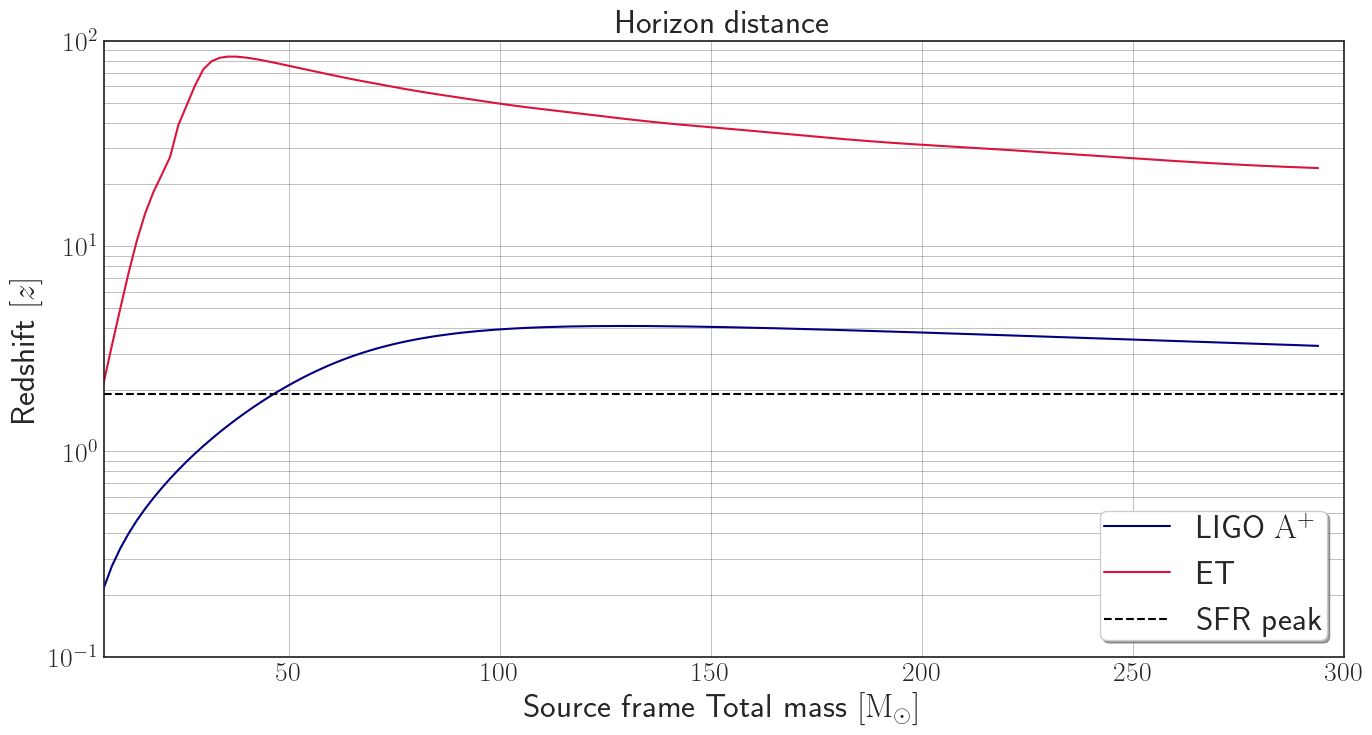

In [31]:
plt.figure(figsize=(16,8))
plt.title('Horizon distance', fontsize = 24)
plt.plot(Horizon_df.TotalMass, Horizon_df.LIGO_RedHorizon, color = 'navy', label = r'LIGO $\rm A^{+}$')
plt.plot(Horizon_df.TotalMass, Horizon_df.ET_RedHorizon, color = 'crimson', label = 'ET')
plt.axhline(SFR_zpeak, color = 'Black', label = 'SFR peak', ls = 'dashed')
plt.xlabel(r'Source frame Total mass $[\rm M_{\odot}]$', fontsize = 24)
plt.ylabel('Redshift $[z]$', fontsize = 24)
plt.ylim(0.1, 100)
plt.yscale('log')
plt.legend(loc = 4, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 24})
plt.xlim(6,300)
plt.grid(which='both', color='grey', linestyle='-', linewidth=0.5, alpha=.7)
#plt.axvline(30)
#plt.xscale('log')
plt.savefig('DetectorHorizonVsz.png', dpi = 200)
#plt.savefig('DetectorHorizonVsz.png', dpi = 50)

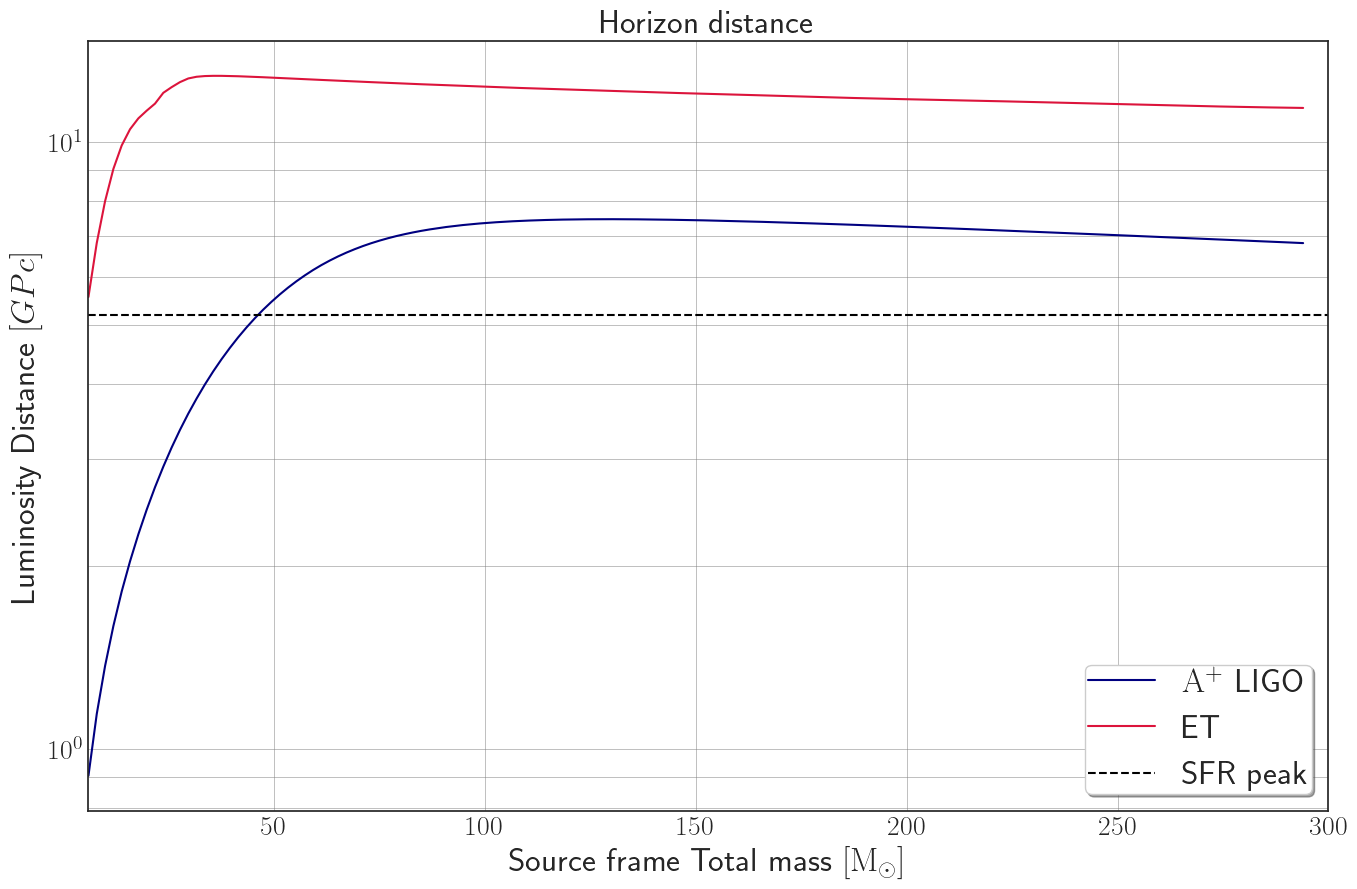

In [32]:
plt.figure(figsize=(16,10))
plt.title('Horizon distance', fontsize = 24)
plt.plot(Horizon_df.TotalMass, Horizon_df.LIGO_DlHorizon, color = 'navy', label = r'$\rm A^{+}$ LIGO')
plt.plot(Horizon_df.TotalMass, Horizon_df.ET_DlHorizon, color = 'crimson', label = 'ET')
plt.axhline(dist_func(SFR_zpeak), color = 'Black', label = 'SFR peak', ls = 'dashed')
plt.xlabel(r'Source frame Total mass $[\rm M_{\odot}]$', fontsize = 24)
plt.ylabel(r'Luminosity Distance $[GPc]$', fontsize = 24)
#plt.ylim(0.1, 10)
plt.yscale('log')
plt.legend(loc = 4, frameon = True, fancybox = True, shadow = True, borderpad= 0.1, prop={'size': 24})
plt.grid(which='both', color='grey', linestyle='-', linewidth=0.5, alpha=.7)
plt.xlim(6,300)
#plt.xscale('log')
plt.savefig('DetectorHorizonVsDl.png', dpi = 200)
#plt.savefig('DetectorHorizonVsDl.png', dpi = 50)